Machine Learning Engineer Nanodegree  
Capstone Project  
Tim Black  
September 20, 2018

# Definition

## Project Overview
In order for cities to plan transportation systems, they need to have robust data on the number of people using different modes of transport. This is especially important when the urban landscape changes, such as an increase in urban density, and cities need to plan for the changes in traffic that will arrive. Typically, cities collect data on the volume of vehicle, bicycle, and pedestrian traffic. Unfortunately, collecting these data is costly and time consuming, and in some cases impossible. Often transportation engineers and planners need to understand the consequences of different design decisions, such as the estimated effect of a traffic signal on safety. Since it is impossible to build out these alternatives and then perform volume counts, engineers and planners need a way to be able to estimate the effect of changes on pedestrian volume.

Although many cities have models to estimate the effect of the built environment on pedestrian volume, they are typically at the scale of traffic analysis zones, a geographic scale much larger compared to the intersection. Intersection-based models exist for the following locations: San Francisco, CA (1,2); Charlotte, NC (3); Alameda County, CA (4); San Diego County, CA (5); Santa Monica, CA (6); and Quebec (7). Most of these intersection-based models use either a linear model, and the most common features found to significantly affect pedestrian volumes include population density, employment density, and transit accessibility.

Despite general agreement on the most important features, there are differences among the models on other significant features from the built environment. For example, the City of Santa Monica found the distance from the ocean to be a significant feature for prediction (6); it is highly unlikely that a landlocked city would find the same to be the case. Even when the models agree on which features of the built environment are significant predictors, they often disagree on the extent to which they influence pedestrian volume. As suggested by Schneider et al., this variation should be addressed by creating models that are sensitive to the context of the local environment (1). Since there currently does not exist a model to predict pedestrian intersection volumes for the City of Los Angeles, this project aims to fill that gap.


## Problem Statement
For this project, I will answer the following questions:

1.  Which features of the built environment are important in predicting pedestrian volume in Los Angeles?

2. What is the best modelling method to predict daily intersection pedestrian volume, and how well can this model predict pedestrian volume at an intersection?

## Metrics
My proposed metric for evaluating my linear model is the r-squared score, the proportion of the variance in the dependent variable that is predictable given the features.  
$${R}^2(y, \hat{y} ) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y})^{2}}{ \sum_{i=1}^{n} (y_i - \bar{y})^{2} }$$

# Data Assembly

The Los Angeles Department of Transportation (LADOT) routinely collects volume data related to bicyclists, pedestrians, and motor vehicles for the purposes of transportation planning. Historically, these data have been stored in a PDF format, which makes it easy to digest a single traffic count, but prevents comparison and analysis of multiple counts. These PDF files are publicly available on the Navigate LA portal at http://navigatela.lacity.org/navigatela/. The first step to solving the proposed problem required extracting pedestrian volume from these sheets and storing it in a format that could be used in a model. 

I developed the following python pipeline below to read the pedestrian volume data from the PDF sheets and format them so they can be used in building the model. The daily volume is represented by the ‘volume’ attribute in the table.  Each row is a separate count event (`count_id`), which occurs at an individual intersection (`ASSETID`, `cl_node_id`).

![Example Volume PDF](images/example_smallest.jpg?raw=TRUE)

In [1]:
import cv2
import numpy as np
from operator import itemgetter, attrgetter
try:
    import Image
except ImportError:
    from PIL import Image
import pytesseract

# Set path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'
# Define config parameters.
# '-l eng'  for using the English language
# '--oem 1' for using LSTM OCR Engine
config = ('-l eng --oem 0 --psm 10000 -c tessedit_char_whitelist=0123456789')

def GetContours(img):
    # Prep image
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    # Run contour analysis, sort by contour area (descending)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse = True)
    return(contours)

def CropImage(img, contour):
    (x, y, w, h) = cv2.boundingRect(contour)
    crop_img = img[y:y+h, x:x+w]
    return(crop_img)

def TesseractText(img):
    text = pytesseract.image_to_string(img, config=config)
    counts = list(map(int, text.split()))
    return(counts)

def ExtractCellVal(cells, img):
    vol = []
    # for each cell, crop & extract text
    for cell in cells:
        (x, y, w, h) = cell[1], cell[2], cell[3], cell[4]
        crop_img = img[y:y+h, x:x+w]
        val = TesseractText(crop_img)
        vol.append(val[0])
    return(vol)
    
def SortPedCells(contours):
    # Get the bounding box of each contour
    contour_list = []
    contour_len = len(contours)
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        contour_list.append([contour, x, y, w, h])
    contour_a = np.array(contour_list)
    # Sort by x coordinate, split by number of columns (in this case, 2)
    contour_a = contour_a[contour_a[:,1].argsort()]
    pedvol = contour_a[:6]
    schvol = contour_a[6:]
    # Sort top to bottom (descending) by y coordinate
    pedvol = pedvol[pedvol[:,2].argsort()]
    schvol = schvol[schvol[:,2].argsort()]
    return(pedvol, schvol)
    
def AnalyzePedCrossingTable(img, pedtbl_contour):
    # Crop Image, get new contours
    crop_img = CropImage(img, pedtbl_contour[0])
    pedvol_contours = GetContours(crop_img)
    pedvol_cells = pedvol_contours[2:14]
    pedvol_cells, schvol_cells = SortPedCells(pedvol_cells)
    pedvol = ExtractCellVal(pedvol_cells, crop_img)
    schvol = ExtractCellVal(schvol_cells, crop_img)
    return(dict([("Ped", pedvol), ("Sch", schvol)]))
    
def GetPedData(img):
    ped_tbl_contours = GetContours(img)[5:9]
    ped_tbls = []
    for ped_tbl_contour in ped_tbl_contours:
        (x, y, w, h) = cv2.boundingRect(ped_tbl_contour)
        ped_tbls.append([ped_tbl_contour, x, y, w, h])
    ped_tbls = np.array(ped_tbls)
    ped_tbls = sorted(ped_tbls, key=itemgetter(1))
    ped_tbls = sorted(ped_tbls, key=itemgetter(2))
    
    ped_sch_extract = {}
    ped_sch_extract['SL'] = AnalyzePedCrossingTable(img, ped_tbls[:1][0])
    ped_sch_extract['NL'] = AnalyzePedCrossingTable(img, ped_tbls[1:2][0])
    ped_sch_extract['WL'] = AnalyzePedCrossingTable(img, ped_tbls[2:3][0])
    ped_sch_extract['EL'] = AnalyzePedCrossingTable(img, ped_tbls[3:4][0])
    
    # Format as final df
    ped_sch_data = []
    for leg in ped_sch_extract:
        for pedtype in ped_sch_extract[leg]:

            ped_sch_dict = {}
            ped_sch_dict['xing_leg'] = leg
            ped_sch_dict['type'] = pedtype
            ped_sch_dict['volume'] = sum(ped_sch_extract[leg][pedtype])
            ped_sch_data.append(ped_sch_dict)
    
    return(ped_sch_data)

After extracting pedestrian volume data from these sheets, I assembled data from the built environment that I thought could possibly be significant in predicting pedestrian volume at intersections in Los Angeles. These data are public, but were assembled for a previous project at LADOT.  I looked to the literature review to inform the types of data to collect for evaluating. My built environment data (explanatory variables) include:

* Population within 0.25 mi.  (`SUM_POPTTL`)
* Employment within 0.25 mi. (`EMPTOT`)
* Count of Schools within 0.25 mi. (`SCH_CT`)
* Presence of a traffic signal (`SIG`, 1 = yes, 0 = no)
* Count of transit stops within 100 ft. (`TRANSITSTOP`)
* Transit Ridership (`RIDERSHIP`)

I also dropped unneeded columns for the analysis. The final data set, which included both the extracted volumes and the built environment data, looked like the following:

In [2]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import assembled data
raw_data = pd.read_csv('data/FeatureData/featurescombined.csv')

# Drop Unnecessary columns, export final table
raw_data = raw_data.drop(['Unnamed: 0', 'count_id','cl_node_id', 'traffic_id', 'type', 'location',
                          'OBJECTID', 'ASSETID', 'CL_NODE_ID', 'FROM_ST', 'TO_ST', 'file'
                         ], axis=1)
print(raw_data.drop(['LAT','LON'], axis=1).head(n=1))

   volume  SIG  TRANSITSTOP  RIDERSHIP  SCH_CT      EMPTOT  SUM_POPTTL
0       9  1.0          1.0        4.0       0  211.024148    7.026113


## Data Cleaning
After completing the data assembly process, I inspected outlier values for the pedestrian volume counts, subsetting out those counts that are outside 3 standard deviations from the mean.

In [3]:
# keep only the ones that are outside +3 to -3 standard deviations of the mean volume
outlier_volume = raw_data[np.abs(raw_data.volume-raw_data.volume.mean()) > (3*raw_data.volume.std())]
print("There are " + str(len(outlier_volume.index)) +
      " volume counts outside +/- 3 st.dev from the mean volume.")

There are 21 volume counts outside +/- 3 st.dev from the mean volume.


I went back to the original PDF files to verify the count information and found 8 counts (of the 21 outliers) where the OCR failed to properly transcribe the values. I removed these 8 inaccurate counts from the dataset. Worried that there was a systematic error in my data processing, I randomly sampled 50 other volume totals. However, among those 50 sampled counts, all of them matched up with the transcribed totals, suggesting that the errors were most likely limited to those outlier totals.

In [4]:
# Drop counts where there was an OCR processing error
raw_data = raw_data.drop([205, 453, 487, 736, 1000, 1107, 1109, 1203])

During my data cleaning, I also found several volume counts that were correctly transcribed to be 0 for the all day count. This was especially odd, given that these counts sometimes occurred in dense areas of the city. 

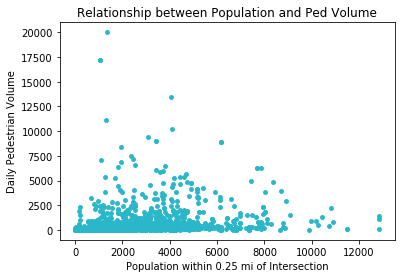

There are 143 counts with volume = 0


In [5]:
# Scatterplot showing relationship between population and pedestrian volume
plt.scatter(raw_data.SUM_POPTTL, raw_data.volume, color='#2AB7CA', s=15)
plt.xlabel("Population within 0.25 mi of Intersection")
plt.ylabel("Daily Pedestrian Volume")
plt.title("Relationship between Population and Ped Volume")
plt.show()
print("There are "+str(len(raw_data[(raw_data.volume == 0)]))+ " counts with volume = 0")

Further investigation yielded the discovery that occassionally LADOT requests vehicle-only counts for intersections. When this is the case, the volume is recorded as 0 for the day. Without any other method of determining when the volume at an intersection truly was 0 and when it was not part of the count, I decided to remove all instances where the volume is equal to 0.  

In [6]:
# Remove counts where pedestrian volume = 0
raw_data = raw_data[(raw_data.volume > 0)]

# Analysis

## Data Exploration & Visualization

### Target Variable (Volume)
Below are the summary statistics for the target variable, weekday pedestrian volume.

In [7]:
print(raw_data.volume.describe())

count     1515.000000
mean       683.248185
std       1481.612605
min          1.000000
25%         85.000000
50%        229.000000
75%        593.000000
max      20005.000000
Name: volume, dtype: float64


The daily number of people at an intersection in Los Angeles, according to these counts, ranges between 1 (after removing all counts equal to 0) and 20,005. Half of the intersections have a daily volume below 200; however, the mean is significantly higher (at 624), suggesting that there are some intersections with significantly higher counts. Using the same  +3 standard deviation threshold as before, I can identify those intersections that appear to be outliers. This calculation resulted in a slightly different set of outliers, since this dataset excludes the erroneous counts.

In [8]:
outlier_volume = raw_data[np.abs(raw_data.volume-raw_data.volume.mean()) > (3*raw_data.volume.std())]
print("There are " + str(len(outlier_volume.index)) +
      " volume counts outside +/- 3 st.dev from the mean volume.")

There are 32 volume counts outside +/- 3 st.dev from the mean volume.


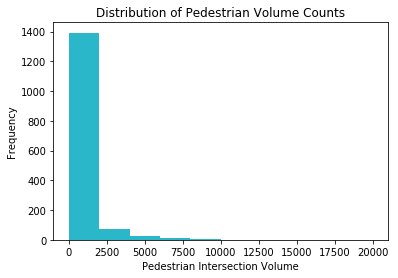

In [9]:
# Histogram of pedestrian volumes
plt.hist(raw_data.volume, color='#2AB7CA')
plt.xlabel("Pedestrian Intersection Volume")
plt.ylabel("Frequency")
plt.title("Distribution of Pedestrian Volume Counts")
plt.show()

As shown in the histogram above, pedestrian volume counts has a heavy skew to the right. ALthough 75% of the counts have a daily volume below 593, some counts are as high as 20,000. This heavy skew suggests that my eventual model will take a transformed version of this variable.

Where are the intersections with the highest volume located in the City of Los Angeles? The map below shows locations with volumes outside 3 standard deviations of the mean.

In [10]:
import folium

# Create new LA Basemap specifying map center, zoom level, and using Stamen Terrain tiles
highvol_map = folium.Map([34.109279, -118.266087],
                         tiles='stamentoner', zoom_start=12)
# Loop through the df, add each highvol point to the map
for index, row in outlier_volume.iterrows():
    folium.CircleMarker([row['LAT'], row['LON']], color='#2AB7CA',
                        popup= ("Volume: {vol}").format(vol=str(int(row['volume']))),
                       radius=5, fill=True, fill_opacity=.5).add_to(highvol_map)
# Show the map
highvol_map

Most of these locations fall within two categories:

1. Directly adjacent to a university: 4 counts are near UCLA, and 1 count is near USC
2. In a dense area: several counts are in Downtown, Hollywood, and Koreatown, some of the most dense areas in the City of Los Angeles  

This suggests that density, measured in dataset by `EMPTOT` and `SUM_POPTTL`, and proximity to a school, measured in the dataset by `SCH_CT`, may be important features in predicting pedestrian volumes. This also suggests that these high counts, despite being outliers in the dataset, should not be discarded since they can be explained by the built environment surrounding them.

### Features
Below are the summary statistics for the features in the dataset. 

In [11]:
print(raw_data.drop(['volume','LAT','LON'], axis=1).describe())

               SIG  TRANSITSTOP      RIDERSHIP       SCH_CT        EMPTOT  \
count  1515.000000  1515.000000     676.000000  1515.000000   1515.000000   
mean      0.516172     0.937294     928.045014     0.734653   2146.467034   
std       0.499903     1.321263    5937.303793     0.939846   5209.780373   
min       0.000000     0.000000       0.000000     0.000000     14.084445   
25%       0.000000     0.000000      43.000000     0.000000    318.393078   
50%       1.000000     0.000000     129.500000     0.000000    713.423911   
75%       1.000000     2.000000     511.500000     1.000000   1668.374141   
max       1.000000     7.000000  104376.101400     7.000000  60793.278700   

         SUM_POPTTL  
count   1515.000000  
mean    2678.297181  
std     1877.970722  
min        0.000000  
25%     1303.732842  
50%     2284.940640  
75%     3557.542856  
max    12858.609440  


The feature `SIG`, presence of a signal, takes on a value of 0 (not present) or 1 (present). The mean value of this feature is .51, indicating that more than half the intersections in the dataset are signalized. The second feature `TRANSITSTOP`, counts the number of transit stops within 100 ft. of the intersection. In many cases, there are no transit stops at the intersection being measured (resulting in a value of 0), but in at least one case there is 7 different transit stops at a single intersection. 

The feature `RIDERSHIP` measures the weekly transit ridership at the intersection. This feature is not normally distributed, with the median transit ridership at an intersection equal to 129 but the mean ridership at 928, suggesting a heavy right skew. Since the transit ridership first depends on a transit stop existing, there were several rows where `RIDERSHIP` has no value (resulting in a row count equal to 676). Since this was the case if a transit stop did not exist, these `NA` values needed to be replaced with the value of 0 in the data preprocessing process. 

The feature `SCH_CT` measures the number of schools (elementary, middle, high, university) within 0.25 mi. of the intersection. In most cases, there is not a single school that close to an instersection; however, at one intersection there is 7 schools nearby.

The features `EMPTOT` and `SUM_POPTTL` measure the density of the area surrounding the intersection. Both are derived from the latest American Communities Survey estimates for people living (`SUM_POPTTL`) and working (`EMPTOT`) within 0.25 mi. of the intersection. The summary statistcs above suggest that these variables are distributed with a right-skew and may also need to be transformed to achieve a normal distribution.

The scatter matrix below shows the relationship between each of the feature pairs as well as the kernel density estimate for each feature in the diagonal.

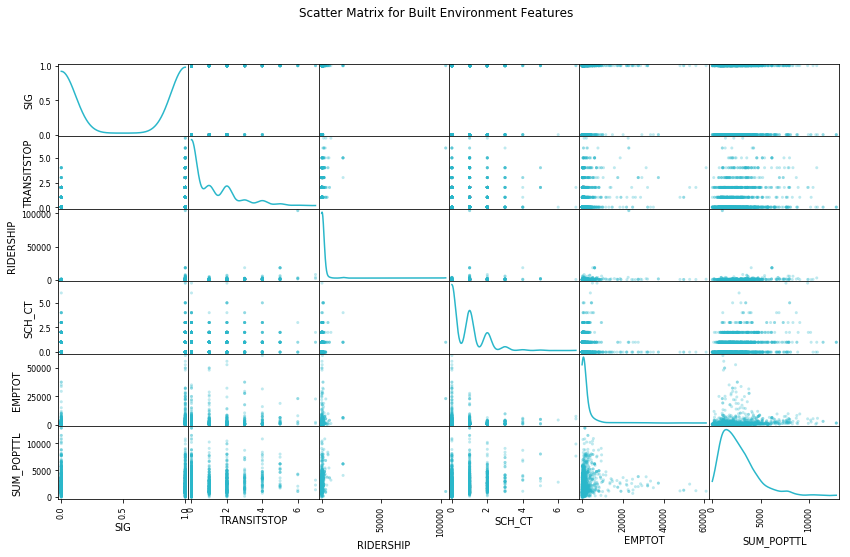

In [12]:
# From customer segments section
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(raw_data.drop(['volume','LAT','LON'], axis=1),
                           alpha = 0.3, figsize = (14,8), diagonal = 'kde',
                           c='#2AB7CA', density_kwds={'color':'#2AB7CA'});
plt.suptitle('Scatter Matrix for Built Environment Features')
plt.show()

The kernel density estimates confirm that two of the features, `EMPTTOT` and `RIDERSHIP`, are not normally distributed and exhibit a heavy right-skew. In order to prevent the very large values from negatively affecting the performance of the algorithm, these features will need to be rescaled during the data preprocessing step. The only qualitative variable, `SIG`, is already coded to the values equal to either `0` (intersection does not contain a signal) or `1` (intersection does contain a signal).    

## Algorithms and Techniques
### Linear Regression
My proposed solution is to build a regression model that can take inputs from the built environment and predict the daily volume of pedestrians at an intersection. For this project, it is not just important to be able to accurately predict the pedestrian volume; it is also important to understand how the characteristics of the built environment affect the volume. A linear regression model produces coefficients that are easy to interpret. In fact, my choice of built-environment features to measure is informed by linear models from previous research. I anticipate my resulting model to take one of two forms shown below:


$Y_i=\beta_0+\beta_1X_{1i}+\beta_2X_{2i}+...\beta_jX_{ji}$  

$Y_i=exp(\beta_0+\beta_1X_{1i}+\beta_2X_{2i}+...\beta_jX_{ji})$  
where:

$Yi$ = weekday pedestrian volume at intersection  

$X_{ji}$ = value of explanatory variable $j$ at intersection $i$  

$\beta_j$ = model coefficient for variable j

### Decision Tree Regression
In addition to linear regression, I will also build a decision tree regressor for comparison. A decision tree regressor will create a set of splitting rules for the feature data to then segment the predictor space into a number of simple regions.  

### Benchmark
There have been a few attempts to build models estimating the effect of the built environment on pedestrian traffic volume, but none have focused on Los Angeles. Most have used a sample set smaller than my own, and almost none reported a test ${R}^2$ alongside the train ${R}^2$. Below is a table with the results from two of these models.

Study | Model Structure | Sample Size (n) | Train R^2 Value | F-Value | Test R^2 Value  
--- | --- | --- | --- | --- | ---
SF (1) | Linear | 50 | 0.804 Adj. | 34.4 | 0.387
SD (5) | Linear | 79 | 0.516 Adj. | 24.112 | None Reported

The San Diego model did not perform a test ${R}^2$, so it is not possible to determine how well the model generalizes. Similarly, the San Francisco model did not initially build a train / test procedure into the modelling process. Instead, after the model was complete, the researchers validated the model with 49 pedestrian counts from a prior study. The correlation between the predicted and actual volumes at those intersections was 0.387. This ${R}^2$ is the benchmark score for comparing the results of this study.

# Methodology
### Data Preprocessing

Most of the data preprocessing for this project is documented in Data Assembly. After assembling the data, the summary statistics revealed that there were several `NA` values for the `RIDERSHIP` feature, which meant that there were no transit stops within 100ft of the intersection. For the purposes of this study, I can interpret this as a `RIDERSHIP` value of 0, so I can fill all the `NA` values with a value of 0 for the analysis.

In [13]:
raw_data['RIDERSHIP'].fillna(0, inplace=True)

### Transforming Skewed Continuous Variables
As also noted in the data exploration, the target variable `volume` and the features `RIDERSHIP` and `EMPTOT` are not normally distributed, all having heavy right skewed distributions. In order to prevent the very large values from negatively affecting the performance of the algorithm, I rescaled them using the natural logarithm. 

In [14]:
# Log-transform the skewed features
# Add 1 to each value before natural log, since log(0) = undefined
skewed = ['RIDERSHIP', 'EMPTOT']
raw_data[skewed] = raw_data[skewed].apply(lambda x: np.log(x + 1))
raw_data.rename(columns = {'RIDERSHIP':'lgRIDERSHIP', 'EMPTOT':'lgEMPTOT'}, inplace = True)

# split features from target variable, create log-transformed version of target variable 
volume = raw_data['volume']
volume_log = raw_data['volume'].apply(lambda x: np.log(x + 1))
volume_log.rename(columns = {'volume':'lgvolume'}, inplace=True)
features = raw_data.drop(['volume','LAT','LON'], axis=1)

# Implementation

In order to assess the true predictive power for each of the models, I split the 1,511 samples into a training and testing set, with 30 percent of the samples held out for testing and the remaining 70 percent used for training and model validation. The initial models included an ordinary least squares (OLS) regression model and a decision trees regression model with a maximum tree depth of five.

In [15]:
# Split the data into train / test sets
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Train / Test Split
index = features.index.values
X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(features, volume_log, index,
                                                    test_size = 0.30, random_state = 0)

# Create linear regression object
regr_ols = linear_model.LinearRegression()

# Create decision tree regressor object
regr_tree = DecisionTreeRegressor(max_depth=5)

# Train the models
regr_ols.fit(X_train, y_train)
regr_tree.fit(X_train, y_train)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1060 samples.
Testing set has 455 samples.


## Refinement
### Linear Regression Model
The linear regression model produces an ${R}^2$ value of 0.484 on the test set, indicating that the model can explain 48% of the variation in log-transformed daily pedestrian volume from the givien features. Both figures below suggest that current linear model is a good fit for the data. The figure below and to the left, a plot of the residuls against the predicted values for the log of the daily pedestrian volumes, shows no discernable pattern. The figure below and to the right shows the residuals to also be normally distributed around 0. 

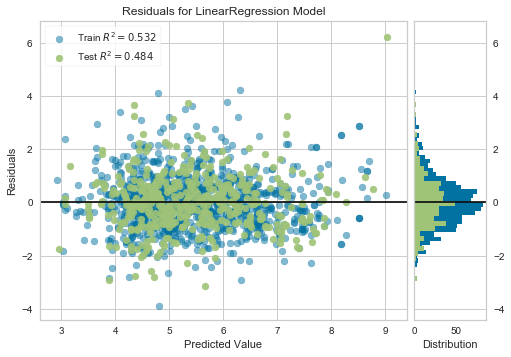

Mean squared error: 1.12


In [16]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import r2_score, mean_squared_error

# Make predictions usgiting the testing set
ols_pred = regr_ols.predict(X_test)

# Instantiate the visualizer, hold off on color selection till package update
visualizer = ResidualsPlot(regr_ols)#, test_color='#615d6c', train_color='#6F8AB7')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, ols_pred))

The figure below shows the results of a regresssion against the non-transformed version pedestrian volume. The evident pattern in the residuals suggests that a linear model with the non-transformed volume data is not a good fit. In additon, the model also shows much lower ${R}^2$ values compared to the model with the log-transformed volumes above.

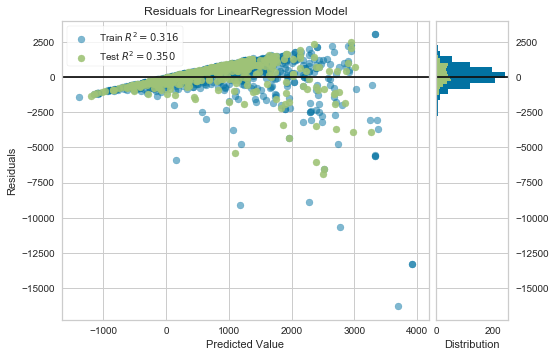

In [17]:
# Train / Test Split with non-transformed volume target variable
X_train_rawvol, X_test_rawvol, y_train_rawvol, y_test_rawvol = train_test_split(features, volume,
                                                            test_size = 0.30,
                                                            random_state = 0)

# Instantiate the visualizer, hold off on color selection till package update
visualizer = ResidualsPlot(regr_ols)#, test_color='#615d6c', train_color='#6F8AB7')
visualizer.fit(X_train_rawvol, y_train_rawvol)
visualizer.score(X_test_rawvol, y_test_rawvol)
visualizer.poof()

In [18]:
import statsmodels.api as sm
from scipy import stats

# produce coefficient estimates using statsmodel pkg
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(est.summary())

C:\Users\dotcid034\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     199.5
Date:                Fri, 21 Sep 2018   Prob (F-statistic):          9.19e-170
Time:                        10:15:37   Log-Likelihood:                -1519.1
No. Observations:                1060   AIC:                             3052.
Df Residuals:                    1053   BIC:                             3087.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6135      0.163      9.869      

The table above shows the coefficients for each of the features in the linear model. All of the features, with the exception of `TRANSITSTOP` are shown to have significant P Values. In addition to not being signifcant in predictor value (with a P Value of .588), the model suggests a relationship with `TRANSITSTOP` that does not make sense. The negative coefficient suggests that pedestrian volume decreases with an increase in the number of transit stops. I removed this feature from future models. 

In [19]:
# Remove Transit Stop Count from feature set
features = features.drop(['TRANSITSTOP'], axis=1)

# Redo Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(features, volume_log,
                                                    test_size = 0.30, random_state = 0)

# Re-Train the models
regr_ols.fit(X_train, y_train)
regr_tree.fit(X_train, y_train)

# Re-print results of OLS
ols_pred = regr_ols.predict(X_test)
print('OLS Test R^2 value: %.2f' % r2_score(y_test, ols_pred))
print("OLS Mean squared error: %.2f"
      % mean_squared_error(y_test, ols_pred))

OLS Test R^2 value: 0.48
OLS Mean squared error: 1.12


### Decision Trees
I re-fit my decision tree model with the updated test/train set (without the `RIDERSHIP` feature). This regressor yielded the similar results as my linear model, with a test ${R}^2$ of 0.47. Decision Tree algorithms allow for several parameters of the model to be tuned to improve predictive performance. In additon to tuning parameters within the model, I decided to add gradient boosting. 

In [20]:
# Decision Tree: Genearte predictions and calculate R^2
tree_pred = regr_tree.predict(X_test)

print("DT Test R^2 value: %.2f" % r2_score(y_test, tree_pred))
print("DT Mean squared error: %.2f"
      % mean_squared_error(y_test, tree_pred))

DT Test R^2 value: 0.47
DT Mean squared error: 1.15


### Improving Decision Trees with Gradient Boosting
To improve the predictive performance of my Decision Tree model, I added gradient boosting, a technique in ensemble learning where new models are added sequentially to correct for the errors in previous models. Gradient boosting reduces these errors through a gradient descent algorithm. Models stop being created when no further improvements can be made; these models are then combined to create a final prediction. Specifically, I decided to use the XGBoost algorithm, which is [one of the most popular algorithms among Kaggle Winning Solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). After performing a grid search on possible parameters, the best performing XGB Model contained the following parameters:

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
import xgboost as xgb

def fit_model(X, y, model, params):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create the grid search object
    grid = GridSearchCV(estimator=model, param_grid=params,
                        scoring='r2', cv=cv_sets, refit=True)

    # Fit the grid search object to the data to compute the optimal model
    grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

params = {
    'objective': ['reg:linear'],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'learning_rate': [0.1],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8],
    'max_depth':[2,4,5,6],
    'min_child_weight':[6,8,10,12],
    'reg_alpha':[10],
    'n_estimators':[1000, 2000, 3000]
}

# XGBoost
data_dmatrix = xgb.DMatrix(data=features, label=volume_log)
xgb_model = xgb.XGBRegressor()

# Fit Model using Grid Search
# regr_xgb = fit_model(X_train, y_train, xgb_model, params)

# Fit Best Perfoming Model with params from grid search
regr_xgb = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.4,
                            learning_rate = 0.1, max_depth = 5, gamma = 0.5,
                            min_child_weight = 6, reg_alpha = 10,
                            n_estimators = 1000)

# Generate Predictions from Model
xgb_pred = regr_xgb.predict(X_test)

# Print Model Form & Results
print(regr_xgb)
print('XGB Test R^2 value: %.2f' % r2_score(y_test, xgb_pred))
print("XGB Mean squared error: %.2f"
      % mean_squared_error(y_test, xgb_pred))

XGB Test R^2 value: 0.56
XGB Mean squared error: 0.95
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=6, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


# Results
## Model Evaluation and Validation

Model Structure | Test R^2 Value | MSE
--- | --- | ---
Linear, Ordinary Least Squares | 0.48 | 1.12
Decision Trees | 0.47 | 1.15
Decision Trees (Boosted) | 0.56 | 0.95

The table above shows the results from my three models. My initial linear OLS model has test ${R}^2$ of 0.48, meaning that the linear model can explain 48% of the variation of pedestrian volume at intersections. I was able to improve this ${R}^2$ to .55 using the Boosted Decision Tree model. Although not my primary metric (since it is not comparable across studies), the mean squared error (MSE) was also lowest for the Boosted Decision Tree model as well, further justifying its selection as the best model for prediction. Since the testing set included randomly selected 455 samples across Los Angeles among the counts, I have a high amount of confidence in my Test ${R}^2$.  Given that the counts were also distributed fairly randomly throughout Los Angeles, I believe my model would generalize well for other counts in the city.

The boxplot below shows the distribution of percent error for predicted volumes in the test set for the linear and boosted decision tree models. 

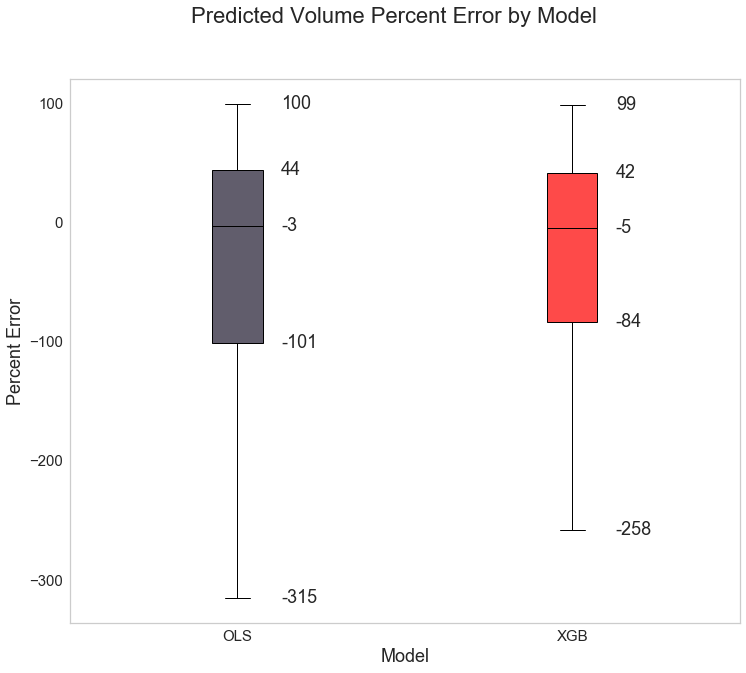

In [22]:
import matplotlib

# Calculate difference between predicted and actual volumes with XGB
xgb_pred_norm = np.exp(xgb_pred).round(0).astype(int)
ols_pred_norm = np.exp(ols_pred).round(0).astype(int)
test_norm = np.exp(y_test).round(0).astype(int)
xgb_pct_diff = ((xgb_pred_norm - test_norm)/xgb_pred_norm)*100
ols_pct_diff = ((ols_pred_norm - test_norm)/ols_pred_norm)*100
diff_df = pd.DataFrame()
diff_df['XGB'] = xgb_pct_diff
diff_df['OLS'] = ols_pct_diff

# Colors for Models
c_xgb = '#fe4a49'
c_ols = '#615d6c'
c_tree = '#fed766'

def add_values(bp, ax):
    """ This actually adds the numbers to the various points of the boxplots"""
    for element in ['whiskers', 'medians', 'caps']:
        for line in bp[element]:
            # Get the position of the element. y is the label you want
            (x_l, y),(x_r, _) = line.get_xydata()
            # Make sure datapoints exist 
            if not np.isnan(y): 
                x_line_center = x_l + (x_r - x_l)/2 
                y_line_center = y  # Since it's a line and it's horizontal
                # overlay the value:  on the line, from center to right
                ax.text(x_line_center+.13, y_line_center, # Position
                        '%.0f' % y, # Value (3f = 3 decimal float)
                        verticalalignment='center', # Centered vertically 
                        fontsize=18, backgroundcolor="white")
# Setup boxplot
fig, axes = plt.subplots(1, figsize=(12, 10))
bp_dict = diff_df.boxplot(column=['OLS','XGB'],
                          showfliers=False,
                          return_type='dict', patch_artist=True)
# Label axes and IQR
add_values(bp_dict, axes)
plt.suptitle('Predicted Volume Percent Error by Model', fontsize=22)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Percent Error', fontsize=18)
axes.grid(False)
plt.tick_params(labelsize=15)
# Color boxplot by model
colors = [c_ols, c_xgb]
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp_dict[element], color='black', linewidth=1)
for patch, color in zip(bp_dict['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

Half of the predicted volumes had a percent error between -77% and +40%. When looking at the absolute value of the errors, half of my predicted values had an error of less than 50%. For exploratory purposes and predictive purposes, I believe this to be an acceptable outcome and in-line with similar research. The SF model, for example, noted that "there were noticable differences (more than 50%) between the model volumes and count volumes at a majority of intersections" (1).

Both distributions are skewed to the left with the most egregious errors occurring when the models underpredict the numer of pedestrians at the intersection. In fact, neither model ever produced a prediction that was more than 100 percent greater than the actual volume count at the intersection. Given this asymmetry in error, these models would be most useful when looking for minimum thresholds of pedestrian volume at an intersection.

The boxplot above does not include outliers. 
- for all models, they don't overpredict by more than 100%. implications for planning...

### Interpreting the Linear Model

In [23]:
# Produce coefficient estimates using statsmodel pkg
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     239.5
Date:                Fri, 21 Sep 2018   Prob (F-statistic):          6.54e-171
Time:                        10:15:42   Log-Likelihood:                -1519.2
No. Observations:                1060   AIC:                             3050.
Df Residuals:                    1054   BIC:                             3080.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6140      0.163      9.876      

The table above shows the effect of each feature on the target variable (log-transformed volume) when holding all other features constant.
* Presence of a Signal: We can expect signalized intersections to have pedestrian volumes that are 87 percent higher compared to those that are not signalized, since exp(.6251) = 1.87.
* Transit Ridership: Both the dependent variable (pedestrian volume) and independent variable (transit ridership) are log transformed, so they will exhibit an elastic relationship. A one percent increase in transit ridership corresponds to a .16 percent increase in the pedestrian volume at the intersection.
* School Count: Each additional school within 0.25 mi. of the intersection results in an increase in the pedestrian volume by 8.16 percent, since exp(.0784) = 1.0816.
* Employment: Both the dependent variable (pedestrian volume) and independent variable (employment) are log transformed, so they will exhibit an elastic relationship. A one percent increase in employment within 0.25 mi. of the intersection yields a .38 percent increase in the pedestrian volume at the intersection.
* Population: A one unit increase in the population within 0.25 mi. of the intersection results in an increase of the pedestrian volume by .02 percent, since exp(.0002) = 1.0002.

### Interpreting the XGBoost Model
Boosted decision trees provide a score that indicates how useful a feature is within the model. Features that are used more often to make key decisions within decision trees are scored as having a higher relative importance. For a single tree, the score is calculated from the amount that each attribute split point improves the performance measure (in this case, the ${R}^2$ value), weighted by the number of observations the node is responsible for. For boosted trees, the feature importance is the average of all the feature scores among the decision trees in the model. 

In [24]:
# Plot feature Importance
print(regr_xgb)
xgb.plot_importance(regr_xgb.estimator, color='#fe4a49')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

GridSearchCV(cv=ShuffleSplit(1060, n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'objective': ['reg:linear'], 'learning_rate': [0.1], 'colsample_bytree': [0.3], 'max_depth': [2, 4, 5, 6], 'min_child_weight': [6, 8, 10, 12], 'reg_alpha': [10], 'n_estimators': [150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)


XGBoostError: need to call fit or load_model beforehand

In this model, employment and population are ranked the highest in terms of feature importance for predciting pedestrian volume.  Transit ridership is also scored to be relatively important in my boosted trees model, while school count and signalized status are far less important in predicting pedestrian volume.

## Justification
Based on the available literature, my results were in-line with my expectations. As discussed in the Benchmark section, it is difficult to compare my results with many of the other models that have been completed, since most did not create a train / test split on the data to begin with. Both of my models outperformed the San Francisco model, which had a higher Adjusted ${R}^2$, but had a worse correlation between predicted and actual volumes on data that was unseen by the model (test ${R}^2$).

Study | Model | Test R^2 Value
--- | ---
SF (1) | Linear, Ordinary Least Squares| 0.39 
This work | Linear, Ordinary Least Squares | 0.48
This work | Decision Trees (Boosted) | 0.55

Both of my final models adress the two parts of my original problem statement:

1. Understanding the affect of features: The linear model produced a an interpretable summary that explains how each of the features will affect the pedestrian volume, holding all other features constant. 
2. Prediction: The XGB model is the best predictor with the ability to explain 55 percent of the variation in log-transfomed daily intersection ped volume. After transforming the volumes back to the original counts, half of the predicted values within the test set had an error of less than 50% of the true value.

# V. Conclusion
## Free-Form Visualization
### Visualizing the Test Results
The map below shows the difference between the predicted and actual values for the pedestrian volume in the test set. The predicted volumes are from the XGB model.

In [ ]:
### Map the predicted/actual volumes in the test set
import math

# Transform log-volume to volume for predicted/actual & add
test_features = raw_data.loc[idx2,]
test_features['pred'] = np.exp(xgb_pred).round(0).astype(int)
test_features['actual'] = np.exp(y_test).round(0).astype(int)

# Create new LA Basemap specifying map center, zoom level, and using Stamen Toner Tiles
testvol_map = folium.Map([34.109279, -118.266087],
                        tiles='Stamen Toner',
                        zoom_start=12)

# Map out locations and document labels
locationlist = test_features[['LAT','LON']].values.tolist()
actual_size = test_features['actual'].values.tolist()
pred_size = test_features['pred'].values.tolist()

# Create Groups
group_pred = folium.FeatureGroup(name='<span style=\\"color: #fe4a49;\\">Predicted</span>')
group_actual = folium.FeatureGroup(name='<span style=\\"color: #2ab7ca;\\">Actual</span>')

# Add Circle Markers to Groups
for point in range(len(actual_size)):
    folium.CircleMarker(locationlist[point], radius=(math.sqrt(actual_size[point]/(math.pi*2))),
                        color='#2ab7ca',
                        popup=(
                            "Predicted: {pred}</br>"
                            "Actual: {act}").format(pred=str(pred_size[point]),
                                                       act=str(actual_size[point])),
                        fill=True, fill_opacity=0).add_to(group_actual)
    folium.CircleMarker(locationlist[point], radius=(math.sqrt(pred_size[point]/(math.pi*2))),
                        color='#fe4a49',
                        popup= (
                            "Predicted: {pred}</br>"
                            "Actual: {act}").format(pred=str(pred_size[point]),
                                                       act=str(actual_size[point])),
                        fill=True, fill_opacity=0).add_to(group_pred)

# Add Groups to Maps
group_pred.add_to(testvol_map)
group_actual.add_to(testvol_map)

# Layer Control / Legend
folium.map.LayerControl('topright', collapsed=False).add_to(testvol_map)

# Show the map
m = testvol_map

import os
import time
from selenium import webdriver
 
delay=5
 
#Save the map as an HTML file
fn='testmap.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)
 
#Open a browser window...
browser = webdriver.Chrome()
#..that displays the map...
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
#Grab the screenshot
browser.save_screenshot('predmap.png')
#Close the browser
browser.quit()

### Visualizing the Entire Dataset of Pedestrian Volumes
Below is a map of all the pedestrian volume counts in Los Angeles used in this analysis, symbolizing the pedestrian volume at each intersection by a circle with the area equal to the volume. The map below supports the general takeaway that there are higher pedestrian volumes near downtown, Hollywood, and koreatown. Volume counts are generally lower in lower-density places such as the San Fernando Valley.

In [ ]:
### Map all the ped data
import math

# Create new LA Basemap specifying map center, zoom level, and using Stamen Toner Tiles
pedvol_map = folium.Map([34.109279, -118.266087],
                        tiles='Stamen Toner',
                        zoom_start=13)

# Map out locations and document labels
locationlist = raw_data[['LAT','LON']].values.tolist()
size = raw_data['volume'].values.tolist()

for point in range(1300):
    folium.CircleMarker(locationlist[point], radius=(math.sqrt(size[point]/(math.pi*2))),
                        popup= ("Volume: {vol}").format(vol=str(size[point])),
                        color='#2ab7ca', fill_opacity=0.2,
                        fill=True).add_to(pedvol_map)

# Show the map
pedvol_map

## Reflection
For this project, I was able to take data that is publicly available to build a model that predicts the daily amount of people at an intersection in the City of Los Angeles, employing two widely used methods for regression: ordinary least squares linear regression and decision trees regression. In addition, I was able to improve the predictive power of my decision tree model by employing gradient boosting.

The most challenging and time-consuming aspect of the project was the preprocessing of the data. I spent a considerable amount of time familiarizing myself with the OpenCV library so that I could employ it on this task. Before implementing the OpenCV / OCR solution to process the data, I originally tried to read the data using PDF text extraction tools; however, the performance using those tools was quite poor, and I didn't feel that it would be relaible enough for this project. The OpenCV library method produced more accurate totals, but could only process a smaller set of the PDFs.

The results of this project were generally in line with results similar efforts elsewhere. As discussed previously, it is difficult to compare results with other efforts that did not perform a train / test methodology, and it is likely that those efforts created models that overfit the training data and therefore would not generalize well. Because of this difference in methodologies, and because the much larger sample size in my study, I feel confident that my models would perform better in a more generalized setting.

## Improvement
One improvement that I could have made earlier on would be to rethink the methodology for transforming at least one of the variables, `SCH_CT`. During the initial data collection, I aggregated across all school types; however, I identified the presence of a university as one of the two factors that seemed to explain the presence of outlier values. It may be the case that the presence of a university affects pedestrian volumes differently than other schools, and should be its own separate variable. 

Generally, given the data that I had to build the model, I feel relatively confident that my model for predcition, the XGBoost Decision Tree algorithm, is likely the best model for prediction. However, there are additional prediction techniques that were not evaluated in this study, such as K-Nearest Neighbors.

Despite having a larger dataset compared to previous similar efforts, this modeling solution could be improved further with more data on the target variable, daily pedestrian volume. The OpenCV / OCR solution was limited to the approximately 1,600 counts; however, there are least 5,000 additional sheets that could not be processed in this effort. Obtaining the volume counts from those sheets this would increase the amount of training data by roughly 4 times.  Beyond what I will be able to get from these historical counts, the field of machine learning has advanced to the point where we can now install cameras and get much larger datasets on ped volume counts. The City of Los Angeles has not yet implemented this strategy for collecting pedestrian counts; however, it is only a matter of time before that becomes standard in many cities. When this does happen, we will have much more 

In addition to more data on the target variable, it is highly likely that a better model could be constructed using additional, different data from the built environment. I was able to assemble the data that the literature has shown to be the most important in terms of predicting pedestrian volume; however, I was not able to get the range of data that other researchers have examined. It is also possible that there is some aspect of the built environment that is important but has not yet been revealed in the research. 

# References
1. Schneider, R. J., T. Henry, M. F. Mitman, L. Stonehill, and J. Koehler. Development and Application of a Pedestrian Volume Model in San Francisco. Transportation Research Record: Journal of the Transportation Research Board, No. 2299, 2012, pp. 65–78.
2. Liu, X., and J. Griswold. Pedestrian Volume Modeling: A Case Study of San Francisco. Association of Pacific Coast Geographers Yearbook, Vol. 71, 2009.
3. Pulugurtha, S. S., and S. R. Repaka. Assessment of Models to Measure Pedestrian Activity at Signalized Intersections. In Transportation Research Record: Journal of the Transportation Research Board, No. 2073, Transportation Research Board of the National Academies, Washington, D.C., 2008, pp. 39-48.
4. Schneider, R. J., L. S. Arnold, and D. R. Ragland. Pilot Model for Estimating Pedestrian Intersection Crossing Volumes. In Transportation Research Record: Journal of the Transportation Research Board, No. 2140, Transportation Research Board of the National Academies, Washington, D.C., 2009, pp. 13-26.
5. Jones, M. G., S. Ryan, J. Donlan, L. Ledbetter, L. Arnold, and D. Ragland. Seamless Travel: Measuring Bicycle and Pedestrian Activity in San Diego County and Its Relationship to Land Use, Transportation, Safety, and Facility Type. Alta Planning and Design and Safe Transportation Research and Education Center, University of California, Berkeley, 2010.
6. Haynes, M., and S. Andrzejewski. GIS Based Bicycle & Pedestrian Demand Forecasting Techniques. Presentation to Travel Model Improvement Program, U.S. Department of Transportation. Fehr & Peers Transportation Consultants, San Francisco, Calif., 2010.
7. Miranda-Moreno, L. F., and D. Fernandes. Modeling of Pedestrian Activity at Signalized Intersections: Land Use, Urban Form, Weather, and Spatiotemporal Patterns. In Transportation Research Record: Journal of the Transportation Research Board, No. 2264, Transportation Research Board of the National Academies, Washington, D.C., 2011, pp. 74-82.